In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Load the CSV files
# The CSV files contain the input parameters
train_params = pd.read_csv('train_parameters.csv') # Train parameters
stations = pd.read_csv('stations.csv') # Station and their chainage
curves = pd.read_csv('curves.csv') # Curves data including start, end, radius
gradients = pd.read_csv('gradients.csv') # Gradient data including start, end
speed_restrictions = pd.read_csv('sr.csv') # Speed restriction associated with curve

# Load the train parameters CSV file
train_params = pd.read_csv('train_parameters.csv')

#print(speed_restrictions.columns)
#print(curves.columns)


In [3]:
# Convert the 'Value' column to a dictionary for easy access
train_params_dict = pd.Series(train_params.Value.values, index=train_params.Parameter).to_dict()

# Extract values from the dictionary
acceleration = float(train_params_dict['Acceleration_rate_1'])
acceleration_switch = float(train_params_dict['Acceleration_rate_2'])
switch_speed = float(train_params_dict['Switch_speed'])
braking_deceleration = float(train_params_dict['Braking_rate'])
max_speed = float(train_params_dict['Maximum_speed']) * 5/18 # Assuming the speed is in km/h, convert to m/s
static_friction = float(train_params_dict['Static_friction'])
rolling_resistance = float(train_params_dict['Rolling_resistance'])
air_resistance = float(train_params_dict['Air_resistance'])
mass = float(train_params_dict['Train_mass'])  # Train weight in tons
#power = float(train_params_dict['Power'])  # Power in kW
mc_mass = float(train_params_dict['MC_mass'])  # Motor car weight
tc_mass = float(train_params_dict['TC_mass'])  # Trailer Car weight
starting_resistance = float(train_params_dict['Starting_resistance'])  # Starting resistance of train
inertia_mass_m = float(train_params_dict['Inertia_mass_m'])  # Intertial coefficient of motor car
inertia_mass_t = float(train_params_dict['Inertia_mass_t'])  # Intertial coefficient of trailer car
motor_nos = float(train_params_dict['Motor_nos'])  # Number of driving motors in train
regen_efficiency = float(train_params_dict['Regeneration_efficiency'])  # Efficiency of regeneration


In [4]:
# Function to calculate resistance using Davis formula
def calculate_resistance_per_ton(v):
    return (static_friction + rolling_resistance * v + air_resistance * v**2) * mass


In [5]:
# Constants and parameters (sample values)
g = 9.81  # gravitational acceleration in m/s²
distance_total = 1000  # Distance between stations in meters (1 km)
speed = 0

# Train parameters (example)
station_stop_time = 30  # seconds (stop time at station)


In [6]:
# Speed restrictions (start chainage, end chainage, restricted speed)
speed_restrictions = [
    {'start': 300, 'end': 400, 'restricted_speed': 18.0},  
    {'start': 700, 'end': 800, 'restricted_speed': 19.0},  
]

In [7]:
def acceleration_phase(v_initial, v_final, accel):
    time_accel = (v_final - v_initial) / accel
    v = np.linspace(v_initial, v_final, 100)
    t = np.linspace(0, time_accel, 100)

    P_accel = []
    for speed in v:
        R = calculate_resistance_per_ton(speed)  # Resistance in N
        force = (mass * accel + R) * 1000  # Total force convert from Tons
        power = force * speed  # Power = Force * Velocity
        P_accel.append(power)

    # Energy consumed during acceleration (integrating power over time)
    energy_accel = np.trapz(P_accel, t)
    # Distance covered during acceleration
    distance_accel = 0.5 * accel * time_accel**2
    return energy_accel, distance_accel, time_accel

In [8]:
# Coasting phase (speed reduces due to resistance)
def coasting_phase(v_initial, distance_remaining, distance_braking):
    v = [v_initial]
    distance_coasted = 0
    dt = 1  # time step in seconds
    time_sr = 0
    energy_coast = 0
    while distance_coasted < distance_remaining - distance_braking:
        R = calculate_resistance_per_ton(v[-1])  # Resistance in N
        decel_due_to_resistance = R / mass /1000  # Deceleration caused by resistance
        new_speed = v[-1] - decel_due_to_resistance * dt  # Speed reduces due to resistance

        if new_speed <= 0:  # Train would stop, but we limit the speed reduction
            break

        v.append(new_speed)
        distance_coasted += new_speed * dt
        # The next block is on energy consumption during coating.
        # You can disable the block by removing Hash
        
        '''
        # Speed restriction module
        sr_exists, sr_energy, sr_distance, sr_time = handle_speed_restriction(new_speed, distance_coasted)
        if (sr_exists):
            print(f'Energy:{sr_energy}, Distance:{sr_distance}, Time:{sr_time}')
            distance_coasted += sr_distance
            time_sr += sr_time
            energy_coast += sr_energy
        '''    

        #print(distance_coasted)
    time_coast = len(v) * dt + time_sr # Total time spent coasting
    #print(f'Coasting time:{time_coast}s')
    return energy_coast, distance_coasted, time_coast  # No energy consumed during coasting


In [9]:
# Braking phase
def braking_phase(v_initial, v_final, decel):
    time_brake = (v_initial - v_final) / decel
    v = np.linspace(v_initial, v_final, 100)
    t = np.linspace(0, time_brake, 100)

    P_brake = []
    for speed in v:
        R = calculate_resistance_per_ton(speed)  # Resistance in N
        F_brake = mass * decel  # Braking force
        F_net = (F_brake - R) * 1000  # Net braking force (braking - resistance) convert from Tons
        power_braking = F_net * speed  # Power during braking
        P_brake.append(-power_braking)  # Negative power (deceleration)

    # Total energy consumed during braking
    total_energy_brake = np.trapz(P_brake, t)
    # Regenerated energy (50% of braking energy is recovered)
    energy_brake = -total_energy_brake * regen_efficiency
    # Net energy used during braking
    #net_energy_brake = total_energy_brake + energy_regen
    # Distance covered during braking
    distance_brake = 0.5 * decel * time_brake**2
    return energy_brake, distance_brake, time_brake


In [10]:
# Handle speed restrictions
def handle_speed_restriction(v_initial, distance_covered):

    net_energy = 0  # Initialize net energy
    total_time = 0  # Initialize total time
    distance_covered = distance_covered
    sr_exists = False
    
    # Braking to restricted speed
    for restriction in speed_restrictions:
        # Check if current distance_covered is within the restriction zone
        if restriction['start'] <= distance_covered <= restriction['end']:
            restricted_speed = restriction['restricted_speed']
            energy_brake, distance_brake, time_brake = braking_phase(v_initial, restricted_speed, braking_deceleration)
            distance_covered += (restriction['end'] - restriction['start'] + distance_brake)
            energy_accel, distance_accel, time_accel = acceleration_phase(restricted_speed, max_speed, acceleration)
            distance_covered += distance_accel
            net_energy = energy_brake + energy_accel
            total_time = time_brake + (restriction['end'] - restriction['start']) / restricted_speed + time_accel
            sr_exists = True
            #print(f'Energy:{net_energy}, Distance:{distance_covered}, Time:{total_time}')
            #print(f"Braking time:{time_brake}, Coasting time:{(restriction['end'] - restriction['start']) / restricted_speed}, Accl Time:{time_accel}")

    return sr_exists, net_energy, distance_covered, total_time


In [11]:
# Simulation of the train journey
def simulate_train_run(speed):
    # 1. Acceleration to maximum speed
    if speed < max_speed: 
        energy_accel, distance_accel, time_accel = acceleration_phase(0, max_speed, acceleration)
        speed = max_speed

    # 2. Coasting phase (losing speed due to resistance)
    distance_remaining = distance_total - distance_accel
    distance_braking = max_speed**2/2/braking_deceleration
    #print(distance_remaining,distance_braking)
    if distance_remaining > distance_braking:
        energy_coast, distance_coast, time_coast = coasting_phase(max_speed, distance_remaining, distance_braking)  # Coast the remaining distance

    # 3. Braking phase to stop at the station
    distance_remaining = distance_total - distance_accel - distance_braking
    if distance_remaining > 0:
        energy_brake, distance_brake, time_brake = braking_phase(max_speed, 0, braking_deceleration)

    #print(f"Braking energy:{energy_brake}, Coasting energy:{energy_coast}, Accl energy:{energy_accel}")
    
    return time_accel, time_coast, time_brake, energy_accel, energy_brake, energy_coast


In [12]:
def plot_speed(time_accel, time_coast, time_brake, max_speed):

    # Create the time and speed arrays for each phase
    t_accel = np.linspace(0, time_accel, 100)  # Acceleration phase
    t_coast = np.linspace(time_accel, time_accel + time_coast, 100)  # Coasting phase
    t_brake = np.linspace(time_accel + time_coast, time_accel + time_coast + time_brake, 100)  # Braking phase
    
    # Speed points for each phase
    v_accel = np.linspace(0, max_speed, 100)  # Speed increases during acceleration
    v_coast = np.full(100, max_speed)  # Speed is constant during coasting
    v_brake = np.linspace(max_speed, 0, 100)  # Speed decreases during braking
    
    # Concatenate the times and speeds for a continuous plot
    time_total = np.concatenate((t_accel, t_coast, t_brake))
    speed_total = np.concatenate((v_accel, v_coast, v_brake))
    
    # Plot the speed vs time
    plt.plot(time_total, speed_total)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title('Speed Profile of the Metro Train')
    plt.grid(True)
    plt.show()

    return

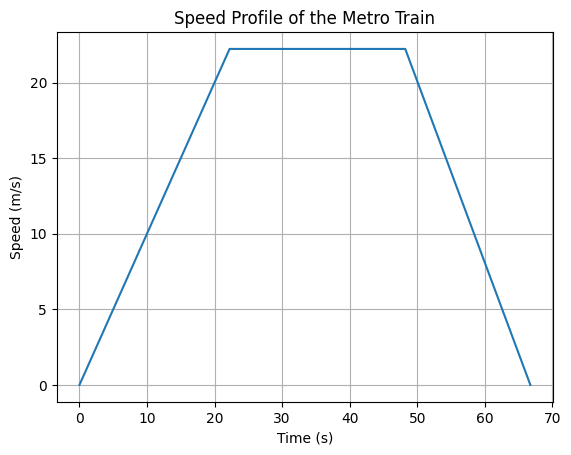

Total Energy Consumed: 167.67 kWh
Average Power: 9044.32 kW
Total Time Taken: 66.74 seconds


In [13]:
# Run the simulation
time_accel, time_coast, time_brake, energy_accel, energy_brake, energy_coast = simulate_train_run(0)

plot_speed(time_accel, time_coast, time_brake, max_speed)

# Total energy consumed (note: no energy during coasting)
total_energy = energy_accel + energy_brake + energy_coast

total_time = time_accel + time_coast + time_brake

# Convert energy from joules to kWh
total_energy_kwh = total_energy / 3600000  # 1 kWh = 3.6 million joules

# Average power for the entire journey (in watts)
average_power = total_energy / total_time  # Average power in watts
average_power_kwh = average_power / 1000  # Convert watts to kilowatts

# Output the results
print(f"Total Energy Consumed: {total_energy_kwh:.2f} kWh")
print(f"Average Power: {average_power_kwh:.2f} kW")  # Convert watts to kilowatts
#print(f"Energy Recovered (Regeneration): {energy_brake * regen_efficiency / 3600000:.2f} kWh")
#print(f"Net Energy Used: {(total_energy - energy_brake * regen_efficiency) / 3600000:.2f} kWh")
print(f"Total Time Taken: {total_time:.2f} seconds")



In [14]:
# Constants
SEC = 50  # Specific Energy Consumption in Wh/ton-km or KWh/1000 ton
mass_in_tons = 200  # Train mass in tons
distance_in_km = 30  # Distance traveled in kilometers (example)
Unit_charge = 7 # Per unit charge in Rupees per KWh


# Step 1: Calculate total energy consumption using SEC
total_energy_wh = SEC * mass_in_tons * distance_in_km / 1000 # in KWh

# Step 2: Calculate Energy charges
energy_bill = total_energy_wh * 7 


# Output the results
print(f"Total Energy Consumption: {total_energy_wh:.2f} KWh")
print(f"Energy Charges: Rs. {energy_bill:.2f} ")


Total Energy Consumption: 300.00 KWh
Energy Charges: Rs. 2100.00 
